*Role Title and Role Code are similar based on pandas
*Instead of using hashing, can consider cantor(m,n) = 1/2 * (m+n)(m+n+1)+m. Beware of hash collision
*PCA / SVD are more suited for continuous values. For discrete variables, consider using MCA
1. Feature Extraction - Using Genetic Algorithm / Greedy Algorithm [sklearn.feature_selection.RFE, RFECV , Gradient Boosting
2. Try using Stacked Classifier 
  * np.mean
  * weighted mean
  * jaccard score
  * pass the results from each classifer into another RF / Linear Regression
3. Data Exploratory - Find if train has more classes compared to test ? 
4. Try to run on Spark
5. Stratified K Fold Cross Validation
6. Use GridSearchCV to optimize Logistic Classifier
7. Consider having equal +ve and -ve examples in each train dataset
8. Count Analysis (Use Log Odd Ratio) + Two Class AdaBoosted Decision Tree

In [1]:
#inside a ipython/nb session
# %store encoder
# %store data
# %store X
# %store X_test
# %store y
# %store features
# %store header
# %store test_offset
# %store rf_data

%store -r encoder
%store -r data
%store -r X
%store -r X_test
%store -r y
%store -r features
%store -r header
%store -r test_offset
%store -r rf_data


In [6]:
import pandas as pd
from pivottablejs import pivot_ui
import seaborn as sb
import matplotlib.pyplot as plt  
from ipywidgets import widgets
import numpy as np
from sklearn import (metrics, cross_validation, linear_model, preprocessing)
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import (GradientBoostingClassifier,RandomForestClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn import grid_search
from itertools import combinations
import pickle

%matplotlib inline

sb.set(style="ticks", color_codes=True)
df = pd.read_csv('train.csv')
dft = pd.read_csv('test.csv')
#g = sb.pairplot(df)

In [ ]:
#Observation Only
df.head()

In [ ]:
#len(df['RESOURCE'].value_counts())
#df['RESOURCE'].plot.hist(bins=7518)

#dfc = df.iloc[:,1:10] 
dfc = df.iloc[:,:]
for col in df.columns:
  dfc[col] = df[col].astype('category')

dfc.describe()


In [ ]:
#Observation Only
#test = pd.pivot_table(dfc,index=['ROLE_TITLE','ROLE_CODE'],aggfunc='count',dropna=True)
#dfc.pivot_table(index='ROLE_TITLE',aggfunc=lambda x:len(x.unique()))
mult = {}
for c in df.columns:
    temp = df.pivot_table(index=c,aggfunc=lambda x:len(x.unique()),fill_value=0).apply(np.max)
    mult[c] = temp

multpd = pd.DataFrame(mult)


In [2]:
def save_results(predictions, filename):
    """Given a vector of predictions, save results in CSV format."""
    with open(filename, 'w') as f:
        f.write("id,ACTION\n")
        for i, pred in enumerate(predictions):
            f.write("%d,%f\n" % (i + 1, pred))


In [ ]:
def cantor(pairs):
    result2 = 0.5 * (pairs[0] + pairs[1]) * (pairs[0] + pairs[1] +1) + pairs[1]
    if(len(pairs) == 2): 
        return result2
    if(len(pairs) == 3 ):
        result3 = 0.5 * (result2 + pairs[2]) * (result2 + pairs[2] +1) + pairs[2]
        return result3
    

In [ ]:
# Convert from dataframe to np.array
y = np.ravel(df.iloc[:,:1])
X = np.array(df.iloc[:,1:9])
X_test = np.array(dft.iloc[:,1:9])
header = list(df.columns[1:])

data = np.vstack((X,X_test))

In [ ]:
# yc = combinations(range(n),2)
# to view all the combinations
# list(yc) 

#train data[:32769,:]
#test data[32769:,:]
#tuple is used here so that the result is hashable

test_offset = 32769
# Get Combinations of 2 features 
for indices in combinations(range(8),2):
    #data = np.column_stack((data,list(ctypes.c_size_t(hash(tuple(v))).value for v in data[:,indices]))) 
    #data = np.column_stack((data,list(np.uint64(hash(tuple(v))) for v in data[:,indices]))) 
    #data = np.column_stack((data,list(hash(tuple(v)) for v in data[:,indices]))) 
    data = np.column_stack((data,list(cantor(tuple(v)) for v in data[:,indices]))) 
    a,b = indices
    header.append(header[a] +"&"+ header[b])
print('2 Combinations')
print(data.shape)
print(np.any(data < 0))
print(np.ndarray.min(data))
print(np.ndarray.max(data))
    
# Get Combinations of 3 features 
for indices in combinations(range(8),3):
    data = np.column_stack((data,list(cantor(tuple(v)) for v in data[:,indices]))) 
    a,b,c = indices
    header.append(header[a] +"&"+ header[b]+ "&" + header[c])

    
#Check loaded correctly with non-zero elements    
print('3 Combinations')
print(data.shape)
print(np.any(data < 0))
print(np.ndarray.min(data))
print(np.ndarray.max(data))

In [ ]:
# Simplify the encoding. Probably not essential. Could possibly improve performance
# Vertical Stacking is required so that all the features are captured. There might be some features in test set not in train set

le = preprocessing.LabelEncoder()
data_e = []
# To perform column wise operations, use Transpose function
for i in data.T:
    le.fit(i)
    data_e.append(le.transform(i))

data = np.asarray(data_e).T

print(np.any(data < 0))
print(np.ndarray.min(data))
print(np.ndarray.max(data))



In [ ]:
# #Code to help Visualize what the algorithm is doing 
# t_data = []
# test_data = np.array([[1,2,3,4],[1,2,2,0],[1,2,3,4],[1,4,5,6],[2,3,4,5]])
# print(test_data.shape)

# #if the combination of categories are the same, they will be hashed to the same value. Eg 1 row with (0,1,0) will have same 
# #hash value of another row with (0,1,0)
# for indices in combinations(range(4),2):
#     t_data.append(hash(tuple(v)) for v in test_data[:,indices])
#     #print(v for v in test_data[:,indices])
#     print(indices)
    
# #Comparison 1 - Combinations are (0,1),(0,2),(0,3),(1,2),(1,3),(2,3)
# # for v in test_data[:,(0,1)]:
# #   print(hash(tuple(v)))

# #Comparison 2 - t_data[0] corresponds to (0,1)
# #tuple(t_data[0])



In [ ]:
#Initial Encoding for all features

encoder = preprocessing.OneHotEncoder(dtype=np.uint32)
# we want to encode the category IDs encountered both in
# the training and the test set, so we fit the encoder on both
encoder.fit(data)
X = encoder.transform(data[:test_offset,:])
X_test = encoder.transform(data[test_offset:,:])
print(X.shape)
print(X_test.shape)

print("Total One Hot Features",encoder.active_features_)
print("Boundaries of each Feature",len(encoder.feature_indices_),encoder.feature_indices_)
print("Number of unique values in each feature",len(encoder.n_values_),encoder.n_values_)
# print(np.unique(data[:,0]))
# print(np.unique(data[:,1]))
# sb.barplot(x=np.arange(92),y=encoder.n_values_)

In [ ]:
#Feature Selection - Gradient Boosting (Filtering)
dtc = DecisionTreeClassifier(criterion='entropy')
dtc.fit(X,y)
print(dtc.feature_importances_)
features = dtc.feature_importances_

#sb.distplot(feat,bins=100)
#print(np.argmax(features),np.max(features))
# Sum features in the same bin as defined by encoder.n_values_
x = 0
start = 0
prob_sum = []
#prob_ref = dict()
for i in encoder.n_values_ : 
    prob = features[start:i].sum()
    prob_sum.append(prob)
    #prob_ref[header[x]] = prob 
    start = i + 1
    #x += 1

In [ ]:
# Stability Selection using Randomized Lasso

rlasso = linear_model.RandomizedLogisticRegression(C=1)
rlasso.fit(X,y)

rlasso_score = rlasso.scores_

x = 0
start = 0
prob_sum = []
for i in encoder.n_values_ : 
    prob_sum.append(rlasso_score[start:i].sum())
    start = i + 1

print(rlasso_score)
print(prob_sum)


In [ ]:
#Feature Selection - Greedy Algorithm (Wrapping)

estimator = linear_model.LogisticRegression(C=1)
selector = RFE(estimator)
selector = selector.fit(X, y)
selector.ranking_

In [ ]:
# Pick out the most useful features

sb.barplot(y=prob_sum,x=np.arange(92))
#hsb = sb.hist(prob_sum,xlim=0.1)
#Look at bar plot to see what threshold of the features to select
ufeatures = []
for i,j in enumerate(prob_sum):
    if (j>0) : ufeatures.append(i)
print(ufeatures)
[header[i] for i in ufeatures]

In [ ]:
# Kaggle Greedy Algorithm result
#ufeatures = [0, 8, 9, 10, 19, 34, 36, 37, 38, 41, 42, 43, 47, 53, 55, 60, 61, 63, 64, 67, 69, 71, 75, 81, 82, 85]
ufeatures = [0, 1, 7, 8, 9, 10, 36, 37, 38, 41, 42, 43, 47, 51, 53, 56, 60, 61, 63, 64, 66, 67, 69, 71, 75, 79, 85, 91]
print(ufeatures)

In [ ]:
#OneHotEncoder for the best features only

encode_bfeat = preprocessing.OneHotEncoder(dtype=np.uint32)
# we want to encode the category IDs encountered both in
# the training and the test set, so we fit the encoder on both
encode_bfeat.fit(data[:,ufeatures])
X = encode_bfeat.transform(data[:test_offset,ufeatures])
X_test = encode_bfeat.transform(data[test_offset:,ufeatures])
print(X.shape)
print(X_test.shape)

In [ ]:
# Testing Random Forest Tree
rf_head = [0,1,22,4,6,35]
rf_data = pd.DataFrame(data)
rf_data = rf_data[rf_head]
rf_data.columns = [header[i] for i in rf_head]

In [3]:
#https://www.kaggle.com/c/caterpillar-tube-pricing/forums/t/15748/strategies-to-encode-categorical-variables-with-many-categories
# One Time Run Completed
#Count/Freq
# for col in rf_data.columns:
#     rf_data['cnt'+col] = 0
#     groups = rf_data.groupby([col])
#     # gid is the grouped col id, group is the actionable pandas data structure
#     for gid, group in groups:
#         #Count total number of rows with the same (MGR_ID,RESOURCE_ID etc) in the entire dataset
#         count = group[col].count()
#         #For all rows with the same "MGR_ID"/"RESOURCE_ID" , put the same count calculated in the previous step
#         rf_data['cnt'+col].ix[group.index] = count 
#     #rf_data['cnt'+col] = rf_data['cnt'+col].apply(np.log) # could check if this is neccesary, I think probably not
    
# # Percent of dept that is this resource
# for col in rf_data.columns[1:6]:
#     rf_data['Duse'+col] = 0.0
#     groups = rf_data.groupby([col])
#     for name, group in groups:
#         grps = group.groupby(['RESOURCE'])
#         for rsrc, grp in grps:
#             rf_data['Duse'+col].ix[grp.index] = float(len(grp.index)) / float(len(group.index) )

# #Number of resources that a manager manages
# for col in rf_data.columns[0:1]:
#     rf_data['Mdeps'+col] = 0
#     groups = rf_data.groupby(['MGR_ID'])
#     for name, group in groups:
#         rf_data['Mdeps'+col].ix[group.index] = len(group[col].unique())

X = rf_data.values[:test_offset,6:18]
X_test = rf_data.values[test_offset:,6:18]

# X = rf_data.values[:test_offset,:]
# X_test = rf_data.values[test_offset:,:]

In [ ]:
#Logistic Regression

SEED = 42
mean_auc = 0.0

n = 10  # repeat the CV procedure 10 times to get more precise results
#model = linear_model.LogisticRegression(C=1,penalty='l2',class_weight='balanced')
#model = BernoulliNB(alpha=0.005)
#model = ensemble.ExtraTreesClassifier(criterion='entropy',n_jobs=-1,verbose=1)
for i in range(n):
    # for each iteration, randomly hold out 20% of the data as CV set
    X_train, X_cv, y_train, y_cv = cross_validation.train_test_split(X, y, test_size=.20, random_state=i*SEED)

    # if you want to perform feature selection / hyperparameter
    # optimization, this is where you want to do it

    # train model and make predictions
    model.fit(X_train, y_train) 
    preds = model.predict_proba(X_cv)[:, 1]

    # compute AUC metric for this CV fold
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, preds)
    roc_auc = metrics.auc(fpr, tpr)
    print("AUC (fold %d/%d): %f" % (i + 1, n, roc_auc))
    mean_auc += roc_auc

print("Mean AUC: %f" % (mean_auc/n))

# === Predictions === #
# When making predictions, retrain the model on the whole training set
model.fit(X, y)
preds = model.predict_proba(X_test)[:, 1]
save_results(preds, "submit.csv")

In [24]:
# Ensemble (Version 1)

SEED = 42
mean_auc = 0.0
coeRF = 0.0
coeET = 0.0
coeGB = 0.0

n = 1 # repeat the CV procedure 10 times to get more precise results
# modelRF = RandomForestClassifier(criterion='entropy',n_estimators=500,max_depth=None,max_features='sqrt',min_samples_split=9,random_state=SEED)
# modelET = ensemble.ExtraTreesClassifier(criterion='entropy',n_estimators=500,max_features='sqrt',min_samples_split=8,max_depth=None,random_state=SEED)
# modelGB = GradientBoostingClassifier(max_depth=20,min_samples_split=9,random_state=SEED,learning_rate=0.2,n_estimators=50)

modelRF = RandomForestClassifier()
modelET = ensemble.ExtraTreesClassifier()
modelGB = GradientBoostingClassifier()


for i in range(n):
    # for each iteration, randomly hold out 20% of the data as CV set
    X_train, X_cv, y_train, y_cv = cross_validation.train_test_split(X, y, test_size=.20, random_state=i*SEED)

    # if you want to perform feature selection / hyperparameter
    # optimization, this is where you want to do it

    # train model and make predictions
    modelRF.fit(X_train, y_train) 
    modelET.fit(X_train, y_train) 
    modelGB.fit(X_train, y_train) 
    
    predsRF = modelRF.predict_proba(X_cv)[:, 1]
    predsRFP = modelRF.predict(X_cv)
    predsET = modelET.predict_proba(X_cv)[:, 1]
    predsGB = modelGB.predict_proba(X_cv)[:, 1]
    predsC = (predsRF + predsET + predsGB)/3
      
    eX = np.hstack((predsRF,predsET,predsGB)).reshape(3,len(predsRF)).transpose()
    modelE = linear_model.LogisticRegression()
    modelE.fit(eX,y_cv)
    
    coeRF += modelE.coef_[0][0]
    coeET += modelE.coef_[0][0]
    coeGB += modelE.coef_[0][0]
    

    # compute AUC metric for this CV fold
    fprRFP, tprRFP, _ = metrics.roc_curve(y_cv, predsRFP)
    fprRF, tprRF, _ = metrics.roc_curve(y_cv, predsRF)
    fprET, tprET, _ = metrics.roc_curve(y_cv, predsET)
    fprGB, tprGB, _ = metrics.roc_curve(y_cv, predsGB)
    fprC, tprC, _ = metrics.roc_curve(y_cv, predsC)
    
    roc_aucRF = metrics.auc(fprRFP, tprRFP)
    roc_aucRF = metrics.auc(fprRF, tprRF)
    roc_aucET = metrics.auc(fprET, tprET)
    roc_aucGB = metrics.auc(fprGB, tprGB)
    roc_aucC = metrics.auc(fprC, tprC)
    
    print("RF AUC (fold %d/%d): %f" % (i + 1, n, roc_aucRF))
    print("ET AUC (fold %d/%d): %f" % (i + 1, n, roc_aucET))
    print("GB AUC (fold %d/%d): %f" % (i + 1, n, roc_aucGB))
    print("Ensemble AUC (fold %d/%d): %f" % (i + 1, n, roc_aucC))
    mean_auc += roc_aucC
    
    fileObject = open("test.pickle",'wb') 
    pickle.dump(RandomForestClassifier,fileObject)   
    fileObject.close()

print("Mean AUC: %f" % (mean_auc/n))
coeRF = coeRF / n
coeET = coeET / n
coeGB = coeGB / n

# === Predictions === #
# When making predictions, retrain the model on the whole training set
modelRF.fit(X, y)
modelET.fit(X, y)
modelGB.fit(X, y)

predsRF = modelRF.predict_proba(X_test)[:, 1]
predsET = modelET.predict_proba(X_test)[:, 1]
predsGB = modelGB.predict_proba(X_test)[:, 1]
predsC = (predsRF + predsET + predsGB)/3

predsE = coeRF * predsRF + coeGB * predsGB + coeET * predsET

save_results(predsC, "submit_e1.csv")
save_results(predsE, "submit_e2.csv")

RF AUC (fold 1/1): 0.806772
ET AUC (fold 1/1): 0.806170
GB AUC (fold 1/1): 0.796830
Ensemble AUC (fold 1/1): 0.854006
Mean AUC: 0.854006


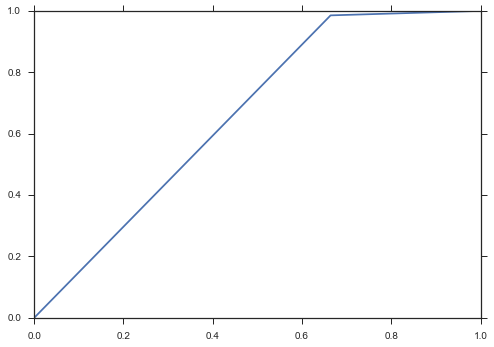

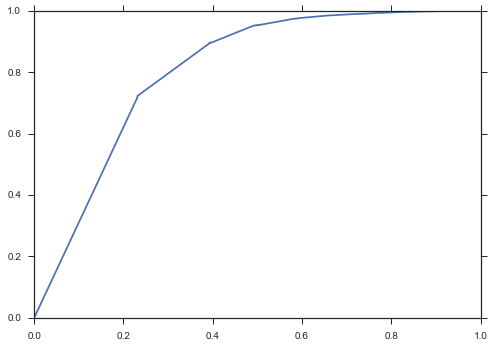

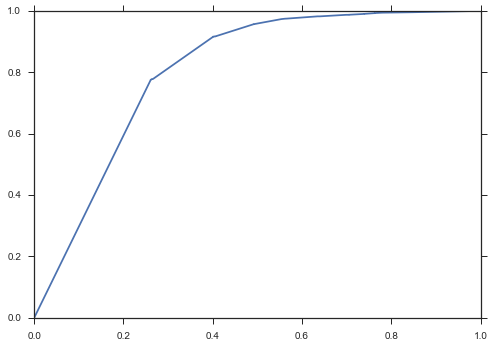

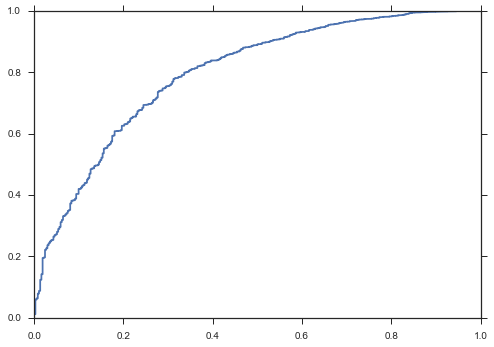

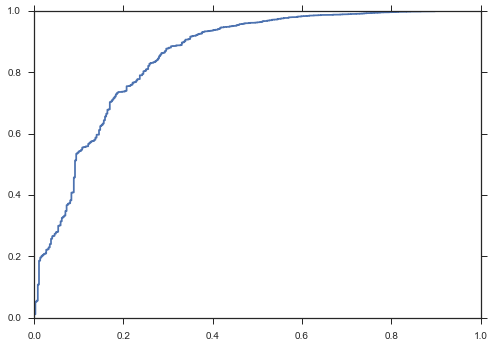

In [25]:
# print(fprRF.shape)
# print(tprRF.shape)
# print(modelRF.predict_proba(X_cv)[1:6,:])
# print(modelRF.predict(X_cv)[1:6])

plt.plot(fprRFP,tprRFP)
plt.show() 

plt.plot(fprRF,tprRF)
plt.show() 

plt.plot(fprET,tprET)
plt.show() 

plt.plot(fprGB,tprGB)
plt.show() 

plt.plot(fprC,tprC)
plt.show() 


In [13]:
#Random Forest Ensemble
# Use FeatureUnion

SEED = 42
mean_auc = 0.0

clf1 = RandomForestClassifier()
clf2 = ensemble.ExtraTreesClassifier()
clf3 = GradientBoostingClassifier()

# modelRF = RandomForestClassifier(criterion='entropy',n_estimators=500,max_depth=None,max_features='sqrt',min_samples_split=9,random_state=SEED)
# modelET = ensemble.ExtraTreesClassifier(criterion='entropy',n_estimators=500,max_features='sqrt',min_samples_split=8,max_depth=None,random_state=SEED)
# modelGB = GradientBoostingClassifier(max_depth=20,min_samples_split=9,random_state=SEED,learning_rate=0.2,n_estimators=50)
#estimators = [('mrf',RandomForestClassifier()),('etc',ExtraTreesClassifier()),('gbc',GradientBoostingClassifier())]
#pipeline = Pipeline([('mrf',RandomForestClassifier())])

eclf = ensemble.VotingClassifier(estimators=[('mrf',clf1),('etc',clf2),('gbc',clf3)],voting='soft')
params = {
    'mrf__n_estimators' : [10,30,50],
    'etc__n_estimators' : [10,30,50],
    'gbc__max_depth' : [5,10],
}

grid = grid_search.GridSearchCV(estimator=eclf,param_grid=params,scoring='roc_auc',n_jobs=-1)
grid.fit(X,y)
print(grid.grid_scores_)
print(grid.best_score_)
print(grid.best_estimator_)
result_grid = grid.predict_proba(X_test)





[mean: 0.85183, std: 0.00538, params: {'mrf__n_estimators': 10, 'gbc__max_depth': 5, 'etc__n_estimators': 10}, mean: 0.85511, std: 0.00868, params: {'mrf__n_estimators': 30, 'gbc__max_depth': 5, 'etc__n_estimators': 10}, mean: 0.85171, std: 0.00657, params: {'mrf__n_estimators': 50, 'gbc__max_depth': 5, 'etc__n_estimators': 10}, mean: 0.84558, std: 0.00879, params: {'mrf__n_estimators': 10, 'gbc__max_depth': 10, 'etc__n_estimators': 10}, mean: 0.84196, std: 0.00758, params: {'mrf__n_estimators': 30, 'gbc__max_depth': 10, 'etc__n_estimators': 10}, mean: 0.84756, std: 0.00856, params: {'mrf__n_estimators': 50, 'gbc__max_depth': 10, 'etc__n_estimators': 10}, mean: 0.84965, std: 0.00556, params: {'mrf__n_estimators': 10, 'gbc__max_depth': 5, 'etc__n_estimators': 30}, mean: 0.85677, std: 0.00786, params: {'mrf__n_estimators': 30, 'gbc__max_depth': 5, 'etc__n_estimators': 30}, mean: 0.85941, std: 0.00588, params: {'mrf__n_estimators': 50, 'gbc__max_depth': 5, 'etc__n_estimators': 30}, mean: 

In [5]:
# Numpy Operations
# print(np.fromiter(t_data[0],np.int32))
# print(np.fromiter(t_data[1],np.int32))
# print(np.fromiter(t_data[2],np.int32))
# print(np.fromiter(t_data[3],np.int32))
# print(np.fromiter(t_data[4],np.int32))
# print(np.fromiter(t_data[5],np.int32))

# Convert to numpy array - Use np.array(list)
# for i in nparray - iterate through rows
# for i in nparray.T - iterate through columns
# Initialize np.zeros(5)

# To view generator operators (Use list,tuples)
# for i,j in enumerate(t_data):
#     #lst_array[i] = np.array(list(j))
#     lst_array[i] = np.fromiter(j,np.float)

AUC = Logistic Regression returns the probability that a certain input features would be in a certain class
ROC curve visualizaes all possible thresholds
Misclassification rate is error rate for a single threshold


Attempt with original features only : CV : ... , Public : 0.88515, Private : 0.88205

Attempt with original features + combination of 3 : CV : 0.886375 , Public : 0.90141, Private 0.89582 
ExtraTreeClassifier = submit_etc.csv


Attempt with original features + combination of 3 : CV : 0.886375 , Public : 0.90141, Private 0.89582 
Logistic C=1, class_weight='balanced',penalty='l2' = submit_c3.csv

Attempt with DTC selected features : CV :  0.886555 (threshold >0) , Public : , Private 
j>0.001 or 0 
Logistic

Attempt with Random Lasso  : CV : 0.886439   , Public : , Private 
j>0
Logistic C=1, class_weight='balanced',penalty='l2' = submit_rl.csv

Cheat Sheet from Kaggle, CV : 0.895952
Logistic C=1, class_weight='balanced',penalty='l2' = submit_kc.csv

In [ ]:
X_test.shape

In [ ]:
predsC.shape

In [ ]:
te1 = np.array([1,2,3,4,5])
te2 = np.array([6,7,8,9,10])
te3 = np.array([11,12,13,14,15])

In [ ]:
teh = np.hstack((te1,te2,te3)).reshape(3,5).transpose()
print(teh)

In [6]:
fileObject = open("test.pickle",'wb') 
pickle.dump(RandomForestClassifier,fileObject)   
fileObject.close()

In [4]:
who_ls
%reset_selective -f b

['BernoulliNB',
 'DecisionTreeClassifier',
 'GradientBoostingClassifier',
 'RFE',
 'RandomForestClassifier',
 'X',
 'X_test',
 'combinations',
 'cross_validation',
 'data',
 'df',
 'dft',
 'encoder',
 'ensemble',
 'features',
 'header',
 'linear_model',
 'metrics',
 'np',
 'pd',
 'pickle',
 'pivot_ui',
 'plt',
 'preprocessing',
 'rf_data',
 'sb',
 'test_offset',
 'widgets',
 'y']